alfie pymongo use

In [1]:
import os
from dotenv import load_dotenv
from pathlib import Path
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd
import ast
import datetime
import seaborn as sns
import json
import numpy as np

import matplotlib as mpl

from datetime import datetime
from dateutil.parser import parse

#need to translate from wgs to bng to do spatial clustering
import pyproj

from pandas.io.json import json_normalize

#now to try out the clustering with this new data set
#now import DBSCAN clustering package
from sklearn.cluster import DBSCAN

#import hierarchical clustering
from scipy import cluster

In [2]:
# specifies number of rows to show
pd.set_option('display.max_rows', 300) 

# specifies default number format to 4 decimal places
pd.options.display.float_format = '{:40,.4f}'.format 

# specifies that graphs should use ggplot styling
plt.style.use('ggplot') 

%matplotlib inline

## Some setups

In [3]:
pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
%matplotlib inline

In [5]:
# load .env variable
# base_dir = 'D:\Documentos\GitHub\CityBlender'
# dotenv_file = os.path.join(base_dir, '.env')

base_dir = 'C:/Users/Alfie/Documents/MSc Smart Cities/Term 2/Spatial Data Capture Storage and Analysis/Coursework/Analysis Test/'
dotenv_file = os.path.join(base_dir, '.env')


# Continue loading stuff

if os.path.isfile(dotenv_file):
    load_dotenv(dotenv_file, verbose=True)
    
db_uri = os.getenv('DB_URI')

db_client = MongoClient(str(db_uri))


# choose a database to connect to (.london)
db_london = db_client.london
status = db_client.london.command('serverStatus')


# create the connections and build the local datasets
db_london_events = db_london['events']
db_london_artist = db_london['artists']

allLondonEvents = db_london_events.find()

londonEventsdf = pd.DataFrame(list(allLondonEvents))

C:\Users\Alfie\Anaconda3\lib\site-packages\pymongo\common.py:555: UserWarning: Unknown option retryWrites
  warnings.warn(str(exc))


# Some processing

In [6]:
# Put this in the date format
londonEventsdf['date'] = [(datetime.strptime(londonEventsdf['date'][x], '%Y-%m-%d')) for x in range(len(londonEventsdf['date']))]

# Convert the dates into day name
londonEventsdf['date_name'] = [(londonEventsdf['date'][x].strftime("%A")) for x in range(len(londonEventsdf['date']))]

# Lat & Long
londonEventsdf['lat'] = [(londonEventsdf['location'][x]['lat']) for x in range(len(londonEventsdf['location']))]
londonEventsdf['lng'] = [(londonEventsdf['location'][x]['lng']) for x in range(len(londonEventsdf['location']))]

# Dates in the dataset

In [7]:
#get min and max date of this dataset
print(min(londonEventsdf['date']))
print(max((londonEventsdf['date'])))

2018-04-13 00:00:00
2018-05-28 00:00:00


In [8]:
# Define some common projections using EPSG codes
wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
osgb36=pyproj.Proj("+init=EPSG:27700") # UK Ordnance Survey, 1936 datum

In [9]:
#create a new pd without NaNs
londonEventsdfNoNan = londonEventsdf[londonEventsdf['lat'].notnull()]

#make new columns for the new latlng
londonEventsdfNoNan['BNGnorthing'] = ""
londonEventsdfNoNan['BNGeasting'] = ""


londonEventsdfNoNan = londonEventsdfNoNan.reset_index()

C:\Users\Alfie\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Alfie\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
#now run through the dataset and transform those coordinates
origLat = []
origLng = []

for i in londonEventsdfNoNan['index']:
    # print(i)
    try:
        origLat.append(londonEventsdfNoNan['lat'][i])
        origLng.append(londonEventsdfNoNan['lng'][i])
        
    except:
        origLat.append(np.nan)
        origLng.append(np.nan)

In [11]:
lat,lon = pyproj.transform(wgs84,osgb36,origLng,origLat)
    
londonEventsdfNoNan['BNGeasting'] = lat
londonEventsdfNoNan['BNGnorthing'] = lon

In [ ]:
londonEventsdfNoNan

In [12]:
londonEventsdfNoNan['BNGnorthing'] = pd.to_numeric(londonEventsdfNoNan['BNGnorthing'])
londonEventsdfNoNan['BNGeasting'] = pd.to_numeric(londonEventsdfNoNan['BNGeasting'])

In [13]:
londonEventsdfNoNan = londonEventsdfNoNan[londonEventsdfNoNan['BNGnorthing'].notnull()]

In [14]:
londonEventsdfNoNan = londonEventsdfNoNan.reset_index()

In [15]:
# Make a function to subset the genere depending on which dataset
def subset_by_genere(db = londonEventsdfNoNan, lib = 'spotify', words = 'reggae'):
    return db[db[lib].astype(str).str.contains(words, case=False)]

In [16]:
reggaeEventsdf = subset_by_genere()

reggaeEventsdf2 = subset_by_genere(lib = 'lastfm')
allReggaeEvents = pd.concat([reggaeEventsdf,reggaeEventsdf2])

In [17]:
#get rid of duplicates
allReggaeEvents = allReggaeEvents.drop_duplicates(subset='_id', keep='last')

In [ ]:
#try folk subset
folkEvents = subset_by_genere(words = 'folk')

In [ ]:
folkEvents2 = folkEvents = subset_by_genere(lib = 'lastfm', words = 'folk')

In [ ]:
allFolkEvents = pd.concat([folkEvents,folkEvents2])

In [ ]:
allFolkEvents = allFolkEvents.drop_duplicates(subset='_id', keep='last')

In [21]:
#create a genre compiling function
def genre_df_compiler(genreName):
    firstEventsdf = genreName+"Eventsdf" 
    secondEventsdf = genreName+"Eventsdf2"
    firstEventsdf = subset_by_genere(lib='spotify',words = genreName)
    secondEventsdf = subset_by_genere(lib='lastfm',words = genreName)
    allEventsdf = "all"+genreName+"Events" 
    allEventsdf = pd.concat([firstEventsdf, secondEventsdf])
    allEventsdf = allEventsdf.drop_duplicates(subset='_id', keep='last')
    return allEventsdf
    
    

In [19]:
def genre_df_loc_array(genreDf):
    genreLocsArray = genreDf[['BNGeasting', 'BNGnorthing']].values
    return genreLocsArray

In [22]:
allJazzEvents = genre_df_compiler("jazz")
jazzLocsArray = genre_df_loc_array(allJazzEvents)

In [ ]:
allJazzEvents

In [ ]:
jazzLocsArray

In [ ]:
allFolkEvents

In [ ]:
allReggaeEvents

In [ ]:
#need to put the lat and lng as an array
locsAsArray = londonEventsdfNoNan[['BNGeasting', 'BNGnorthing']].values

In [ ]:
locsAsArray

In [ ]:
#now get reggae locs
regLocsAsArray = allReggaeEvents[['BNGeasting', 'BNGnorthing']].values

In [ ]:
regLocsAsArray

In [ ]:
folkLocsAsArray = allFolkEvents[['BNGeasting', 'BNGnorthing']].values

In [ ]:
folkLocsAsArray


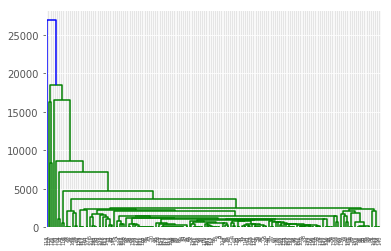

In [24]:
#Ripley's k is rubbish, let's try using hierarchical clustering to work out how large to set the eps
jazzCluster = cluster.hierarchy.linkage(jazzLocsArray)
cluster.hierarchy.dendrogram(jazzCluster);


In [29]:
#try out a dbscan of all reggae
#create new dbscan cluster objects with samples 10
dbscan500by10 = DBSCAN(eps=500, min_samples=10)
dbscan750by10 = DBSCAN(eps=750, min_samples=10)
dbscan1000by10 = DBSCAN(eps=1000, min_samples=10)
dbscan1500by10 = DBSCAN(eps=1500, min_samples=10)
dbscan2000by10 = DBSCAN(eps=2000, min_samples=10)

#new dbscan objects with samples 5
dbscan500by5 = DBSCAN(eps=500, min_samples=5)
dbscan750by5 = DBSCAN(eps=750, min_samples=5)
dbscan1000by5 = DBSCAN(eps=1000, min_samples=5)
dbscan1500by5 = DBSCAN(eps=1500, min_samples=5)
dbscan2000by5 = DBSCAN(eps=2000, min_samples=5)

#new dbscan objects with samples 3
dbscan500by3 = DBSCAN(eps=500, min_samples=3)
dbscan750by3 = DBSCAN(eps=750, min_samples=3)
dbscan1000by3 = DBSCAN(eps=1000, min_samples=3)
dbscan1500by3 = DBSCAN(eps=1500, min_samples=3)
dbscan2000by3 = DBSCAN(eps=2000, min_samples=3)

In [ ]:
#get only locations from the reggae set
#get just locations
#use the locsArray again

dbscanAllEvents = dbscan.fit(locsAsArray)

In [ ]:
#get the labels of the groups
dbscanLabelsAllEvents = dbscan.labels_

In [ ]:
dbscanLabelsAllEvents

In [ ]:
#now add the labels back into the reggae dataframe
#need to reindex allReggaeEvents for it to work
#londonEventsdfNoNan = londonEventsdfNoNan.reset_index()

In [ ]:
londonEventsdfNoNan['dbscanLabelsAllEvents'] = pd.DataFrame(dbscanLabelsAllEvents)

In [25]:
#function for creating a dbscan grouping of events
def dbscan_genre_cluster(genredf, dbscan, colName):
    locsArray = genre_df_loc_array(genredf)
    dbscan.fit(locsArray)
    dbscanClusterLabels = dbscan.labels_
    genredf[colName] = pd.DataFrame(dbscanClusterLabels)
    return genredf

In [27]:
dbscan_genre_cluster(allJazzEvents,dbscan1000,'jazzDBSCAN1000')

In [28]:
allJazzEvents

,level_0,index,_id,artists,date,datetime,datetime_source,foursquare,id,lastfm,...,time,type,url,venue,date_name,lat,lng,BNGnorthing,BNGeasting,jazzDBSCAN1000
20,20,20,5af9c7130cc9ab0004e227ff,"[{'mbid': [], 'id': 5581788, 'name': 'Tony Mal...",2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '4b08016df964a520320223e3', 'name': 'Vo...",33428984,"{'listeners': [7], 'listeners_sum': 7, 'playco...",...,19:00:00,Concert,http://www.songkick.com/concerts/33428984-tony...,"{'id': 7012, 'name': 'Vortex Jazz Club', 'loca...",Monday,51.5487,-0.0765,"185,066.0063","533,468.0048",-1.0000
151,151,151,5afab9c5dcab560004a0af71,[{'mbid': ['7c3626b0-5f9d-4415-9a9d-f8770f4d6b...,2018-05-16,2018-05-16 18:00:00,2018-05-16T19:00:00+0100,"{'id': '5807d81f38fa0c5319eb08df', 'name': 'Om...",33683804,"{'listeners': [3466, 15630, 13448], 'listeners...",...,19:00:00,Concert,http://www.songkick.com/concerts/33683804-joel...,"{'id': 3375829, 'name': 'Omeara', 'location': ...",Wednesday,51.5041,-0.0946,"180,077.3475","532,341.8876",-1.0000
172,172,172,5afaba02dcab560004a0afa4,[{'mbid': ['85e65d5f-4d9b-407d-b261-882caa52bf...,2018-05-17,2018-05-17 18:00:00,2018-05-17T19:00:00+0100,"{'id': '4bc76e872f94d13a36ea117f', 'name': 'O2...",32168414,"{'listeners': [85166, 183], 'listeners_sum': 8...",...,19:00:00,Concert,http://www.songkick.com/concerts/32168414-prem...,"{'id': 38323, 'name': 'O2 Academy Islington', ...",Thursday,51.5346,-0.1059,"183,442.0679","531,468.8547",3.0000
199,199,199,5afaba4cdcab560004a0afe5,"[{'mbid': [], 'id': 8948809, 'name': 'PFM Prem...",2018-05-17,2018-05-17 17:30:00,2018-05-17T18:30:00+0100,"{'id': '4bc76e872f94d13a36ea117f', 'name': 'O2...",33217009,"{'listeners': [85166], 'listeners_sum': 85166,...",...,18:30:00,Concert,http://www.songkick.com/concerts/33217009-pfm-...,"{'id': 1064401, 'name': 'O2 Academy 2 Islingto...",Thursday,51.5346,-0.1059,"183,442.0679","531,468.8547",nan
272,272,272,5afabb26dcab560004a0b099,[{'mbid': ['0fc04d4a-e795-49b3-814b-02f7517666...,2018-05-18,2018-05-18 22:00:00,2018-05-18T23:00:00+0100,"{'id': '4ac518c9f964a52094a520e3', 'name': 'Fa...",32868499,"{'listeners': [50751, 59086, 2451, 43251, 1183...",...,23:00:00,Concert,http://www.songkick.com/concerts/32868499-art-...,"{'id': 8850, 'name': 'fabric', 'location': {'l...",Friday,51.5196,-0.1025,"181,776.8118","531,750.9378",nan
300,300,300,5afabb8ddcab560004a0b0ee,[{'mbid': ['00f29491-a87d-47d4-abd8-8c49067a48...,2018-05-18,NaT,None,"{'id': '529914c5498ee1d13944a93b', 'name': 'Th...",33506839,"{'listeners': [176], 'listeners_sum': 176, 'pl...",...,None,Concert,http://www.songkick.com/concerts/33506839-jazz...,"{'id': 3279, 'name': 'The Crypt', 'location': ...",Friday,51.4736,-0.0872,"176,689.8663","532,946.3022",nan
392,392,392,5afabd0edcab560004a0b20b,[{'mbid': ['ab102e9a-1fde-4694-8367-6ec68a312f...,2018-05-19,2018-05-19 18:00:00,2018-05-19T19:00:00+0100,"{'id': '4ac518ebf964a52041ac20e3', 'name': 'Vi...",33466534,"{'listeners': [9845], 'listeners_sum': 9845, '...",...,19:00:00,Concert,http://www.songkick.com/concerts/33466534-izem...,"{'id': 628031, 'name': 'Village Underground', ...",Saturday,51.5238,-0.0780,"182,291.9710","533,434.4336",nan
759,759,759,5afaee7df4259d0004b0e619,[{'mbid': ['5ce64ed9-3015-4910-a2bb-1cd5c933de...,2018-04-15,2018-04-15 18:30:00,2018-04-15T19:30:00+0100,NaN,30576499,"{'listeners': [93219], 'listeners_sum': 93219,...",...,19:30:00,Concert,http://www.songkick.com/concerts/30576499-sonn...,"{'id': 30247, 'name': '229', 'location': {'lng...",Sunday,51.5235,-0.1442,"182,137.4000","528,841.9670",nan
898,898,898,5afaefe7f4259d0004b0e765,[{'mbid': ['812c46e5-3d65-4e80-ada8-269450c562...,2018-04-18,2018-04-18 22:00:00,2018-04-18T23:00:00+0100,NaN,32536464,"{'listeners': [80793], 'listeners_sum': 80793,...",...,23:00:00,Concert,http://www.songkick.com/concerts/32536464-jord...,"{'id': 36418, 'name': 'Ronnie Scott's', 'locat...",Wednesday,51.5135,-0.1315,"181,051.7064","529,753.3538",nan
917,917,917,5afaf027f4259d0004

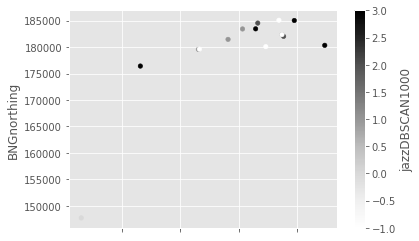

In [30]:
#now give it a plot
#define colorscheme

allJazzEvents.plot.scatter(y='BNGnorthing', x='BNGeasting', c='jazzDBSCAN1000')

In [ ]:
#try clustering out on the whole dataset
dbscan2ndRun = dbscan.fit(locsAsArray)

In [ ]:
londonEventsdf

In [34]:
import folium
from matplotlib import colors

In [36]:
#trying out a map of this clustering
#create a map with our data in center
this_map = folium.Map([51.517717, -0.108407], zoom_start=12, tiles="Cartodb Positron", control_scale=True)




#create a color dictionary for with custom buckets
buckets = [(1,2+1),(3,5+1),(6,10+1),(11,49+1),(50,136+1)]
color_names = ['blue','lightskyblue','limegreen','orange','red']
color_dict = {}
for n in range(len(buckets)):
    for m in range(buckets[n][0],buckets[n][1]):
        color_dict[m] = colors.to_hex(color_names[n])

#populate with the map listings, make pop up text=the number of other listings the host has
for n in allJazzEvents.index:
    alist = allJazzEvents.loc[n]
    plot_val = alist.jazzDBSCAN1000
    popup_text = str(plot_val)
    folium.CircleMarker(location=[alist.lat, alist.lng], radius=1).add_to(this_map)
this_map.fit_bounds(this_map.get_bounds())
#Save the map as an html file

In [37]:
this_map